In [190]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [191]:
def cosine(m):
    d = m.T @ m
    norm = (m * m).sum(0, keepdims=True) ** .5
    return d / norm / norm.T

def reduce(pos):
    model = PCA(n_components=2)
    W = model.fit_transform(pos)
    H = model.components_
    return W

# Visualization

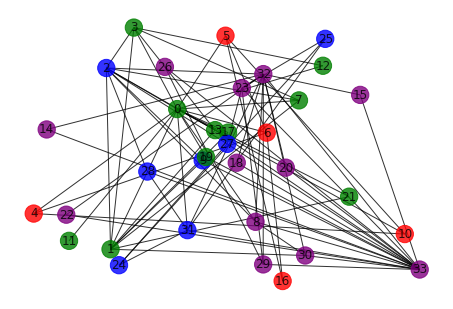

In [192]:
G = nx.karate_club_graph()
np.random.seed(200)

# position
pos = np.random.random((34, 34))
pos2 = reduce(pos)
diction = {}
for i in range(pos2.shape[0]):
    diction[i] = pos2[i]

# the same labeling as the same labeling as https://arxiv.org/abs/1609.02907 and https://arxiv.org/abs/1403.6652
class1 = [4, 6, 5, 10, 16]
class2 = [2, 9, 24, 25, 27, 28, 31]
class3 = [0, 1, 3, 7, 11, 12, 13, 17, 19, 21]
class4 = [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]

node_color, Label = [], []
for i in range(34):
    if i in class1:
        node_color.append('red'); Label.append(0)
    elif i in class2:
        node_color.append('blue'); Label.append(1)
    elif i in class3:
        node_color.append('green'); Label.append(2)
    else:
        node_color.append('purple'); Label.append(3)
        
nx.draw(G, diction,
        node_color=node_color,
        alpha = 0.8,
        with_labels=True)

# Model

In [196]:
import math

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch_layer_normalization import LayerNormalization


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.count = 0
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.spmm(adj1, input)
        output = torch.mm(support,  self.weight)

        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, nL, parity):
        super(GCN, self).__init__()
        self.nL = nL
        self.gc = GraphConvolution(nfeat, nhid)
        for i in range(self.nL):
            name = "gcn_for{}".format(i+1)
            self.add_module(name, GraphConvolution(nhid, nhid))
        self.dropout = dropout
        self.parity = parity

    def forward(self, x, adj):
        temp, c, d = [x], [], []
        for i, Module in enumerate(self.modules()):
            if i == 0:
                continue
            elif i == 1:
                x1 = F.relu(Module(temp[-1], adj))
                x1 = F.dropout(x1, self.dropout, training=self.training)
                temp.append(x1)
            elif i < 3 + self.parity:
                x1 = F.relu(Module(temp[-1], adj))
                temp.append(x1)
            elif i < self.nL + 1:
                x1 = F.relu(Module(temp[-1], adj)) + temp[-2]
                temp.append(x1)
            elif i == self.nL + 2:
                x1 = Module(temp[-1], adj)
            if i < self.nL + 2:
                tmp = Module(temp[-2], adj).detach().numpy()
                c.append(np.abs(cosine(tmp + 1e-9 * np.random.randn(34, 16))).sum() / 16 / 16)
                d.append(np.abs(cosine(tmp.T + 1e-9 * np.random.randn(16, 34))).sum() / 34 / 34)
        return F.log_softmax(x1, dim=1), c, d

# Preprocess

In [197]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

A = nx.adjacency_matrix(G)

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def normalize(mx, f = 0):
    """Row-normalize sparse matrix"""
    if f == 0:
        rowsum = np.array(mx.sum(1)) ** 0.5
    else:
        rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    if f == 0:
        mx = r_mat_inv.dot(mx).dot(r_mat_inv)
    else:
        mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

idx_train = np.array([0, 2, 4, 8, 6, 24, 7, 18])
idx_val = np.array(list(set([i for i in range(34)]) - set([0, 2, 4, 8, 6, 24, 7, 18])))
idx_test = np.array(list(set([i for i in range(34)]) - set([0, 2, 4, 8, 6, 24, 7, 18])))
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

features = normalize(np.eye(34), 1)
adj = normalize(A + sp.eye(adj.shape[0]), 1)

features = torch.FloatTensor(np.array(features))
labels = torch.LongTensor(Label)
adj = sparse_mx_to_torch_sparse_tensor(adj)

# Training

In [199]:
model = GCN(nfeat=34,
            nhid=16,
            nclass=4,
            nL=32,
            dropout=0.5,
            parity=1)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
D_minus_half = np.diag(np.array(A.todense().sum(axis=1)).flatten() ** (-0.5))

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, t1, t2 = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    l2 = 0
    for p in model.parameters():
        l2 = l2 + (p ** 2).sum()
    loss_train = loss_train + 2e-5 * l2
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    L_0.append(loss_train.item())
    L_reg.append(np.trace(output.detach().numpy().T @ (np.eye(34) - D_minus_half @ A.todense() @ D_minus_half) @ output.detach().numpy()))
    return loss_train.item(), acc_train.item(), loss_val.item(), acc_val.item(), t1, t2

def test():
    # model.eval()
    output, _, _ = model(features, adj)
    loss_test = F.nll_loss(output[idx_val], labels[idx_val])
    acc_test = accuracy(output[idx_val], labels[idx_val])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
        
L, R, L_0, L_reg = [], [], [], []

Epoch = 500
for i in range(20):
    print (i)
    model = GCN(nfeat=34,
            nhid=16,
            nclass=4,
            nL=32,
            dropout=0.5,
            parity=i%2)

    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    left, right = [], []
    for epoch in range(Epoch):
        loss1, acc1, loss2, acc2, t1, t2 = train(epoch)
#         print (loss1, acc1, loss2, acc2)
        if epoch in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 499]:
            left.append(t1); right.append(t2)
    test()
        
    L.append(left); R.append(right)

0
Test set results: loss= 0.5857 accuracy= 0.8077
1
Test set results: loss= 0.5321 accuracy= 0.8846
2
Test set results: loss= 0.3700 accuracy= 0.8846
3
Test set results: loss= 0.3546 accuracy= 0.9231
4
Test set results: loss= 0.4495 accuracy= 0.8077
5
Test set results: loss= 0.2906 accuracy= 0.8462
6
Test set results: loss= 0.8444 accuracy= 0.8462
7
Test set results: loss= 0.0295 accuracy= 1.0000
8
Test set results: loss= 0.1437 accuracy= 0.9231
9
Test set results: loss= 0.1778 accuracy= 0.9231
10
Test set results: loss= 0.0620 accuracy= 0.9615
11
Test set results: loss= 1.0263 accuracy= 0.8077
12
Test set results: loss= 0.8876 accuracy= 0.7692
13
Test set results: loss= 0.2339 accuracy= 0.8846
14
Test set results: loss= 0.2790 accuracy= 0.8846
15
Test set results: loss= 0.4482 accuracy= 0.8846
16
Test set results: loss= 1.0205 accuracy= 0.7692
17
Test set results: loss= 0.4997 accuracy= 0.8077
18
Test set results: loss= 0.3694 accuracy= 0.9231
19
Test set results: loss= 1.1403 accurac

# Plot

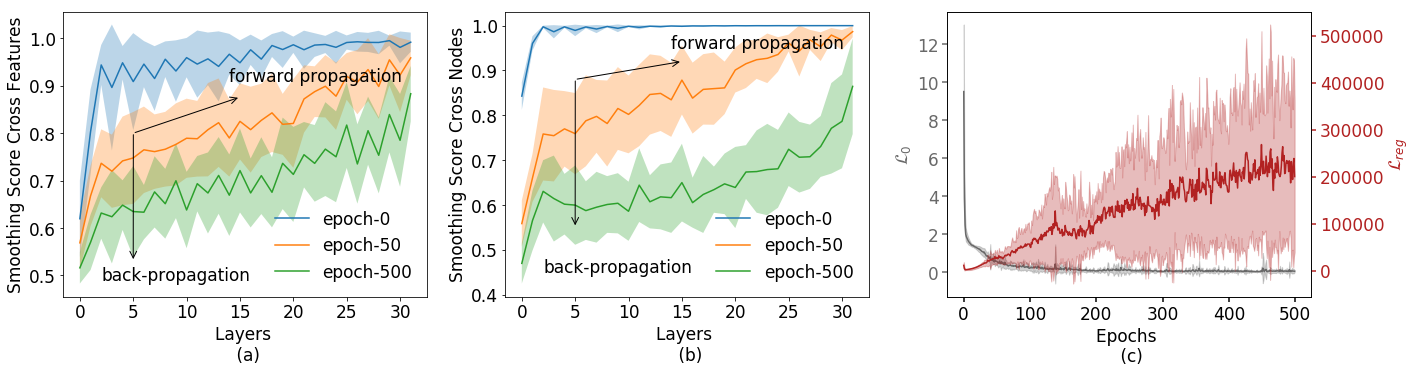

In [227]:
L = np.array(L)
L_ = L[:, [0, 4, -1], :-1]
L_mean = L_.mean(axis=0)
L_std = L_.std(axis=0)

R = np.array(R)
R_ = R[:, [0, 5, -1], :-1]
R_mean = R_.mean(axis=0)
R_std = R_.std(axis=0)

s = 17

plt.figure(figsize=(20,5.5))

plt.subplot(131)
plt.rc('font', size=17)
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
plt.rcParams['image.cmap'] = 'gray'

colors = plt.cm.jet(np.linspace(0.6, 0.9,20))[::-1]

for i in range(3):
    plt.plot(L_mean[i,:])
    plt.fill_between(np.arange(32), L_mean[i,:] - L_std[i,:], L_mean[i,:] + L_std[i,:], alpha = 0.3)

plt.xlabel('Layers \n (a)', fontsize=s)
plt.ylabel('Smoothing Score Cross Features', fontsize=s)
plt.legend(['epoch-0', 'epoch-50', 'epoch-500'], frameon=False, loc='lower right')

from pylab import *
from numpy import *
plt.annotate("",
            xy=(15, 0.876), xycoords='data',
            xytext=(5, 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("",
            xy=(5, 0.53), xycoords='data',
            xytext=(5.01, 0.801), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("forward propagation",
            xy=(14, 0.91), xycoords='data',
            xytext=(14, 0.91), textcoords='data',)

plt.annotate("back-propagation",
            xy=(2, 0.49), xycoords='data',
            xytext=(2.01, 0.49), textcoords='data',
            )

plt.subplot(132)

for i in range(3):
    plt.plot(R_mean[i,:])
    plt.fill_between(np.arange(32), R_mean[i,:] - R_std[i,:], R_mean[i,:] + R_std[i,:], alpha = 0.3)

    
plt.xlabel('Layers \n (b)', fontsize=s)
plt.ylabel('Smoothing Score Cross Nodes', fontsize=s)
plt.legend(['epoch-0', 'epoch-50', 'epoch-500'], frameon=False, loc='lower right')

plt.annotate("",
            xy=(15, 0.92), xycoords='data',
            xytext=(5, 0.88), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("",
            xy=(5, 0.55), xycoords='data',
            xytext=(5.01, 0.881), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("forward propagation",
            xy=(14, 0.95), xycoords='data',
            xytext=(14, 0.95), textcoords='data',)

plt.annotate("back-propagation",
            xy=(2, 0.45), xycoords='data',
            xytext=(2.01, 0.45), textcoords='data',
            )

left_axis = plt.subplot(133)
 
right_axis = left_axis.twinx()
 
mean1 = np.array(L_0).reshape(-1, Epoch).mean(axis=0)
std1 = np.array(L_0).reshape(-1, Epoch).std(axis=0)

mean2 = np.array(L_reg).reshape(-1, Epoch).mean(axis=0)
std2 = np.array(L_reg).reshape(-1, Epoch).std(axis=0)
std2[138] *= 0.3

p1, = left_axis.plot(mean1, 'dimgrey')
left_axis.fill_between(np.arange(Epoch), mean1 - std1, mean1 + std1, color='dimgrey', alpha = 0.3)
p2, = right_axis.plot(mean2, 'firebrick')
right_axis.fill_between(np.arange(Epoch), mean2 - std2, mean2 + std2, color='firebrick', alpha = 0.3)
 
left_axis.set_xlabel('Epochs \n (c)', fontsize=s)
left_axis.set_ylabel('$\mathcal{L}_0$', fontsize=s)
right_axis.set_ylabel('$\mathcal{L}_{reg}$', fontsize=s)
 
left_axis.yaxis.label.set_color(p1.get_color())
right_axis.yaxis.label.set_color(p2.get_color())
 
tkw = dict(size=5, width=1.5)
left_axis.tick_params(axis='y', colors=p1.get_color(), **tkw)
right_axis.tick_params(axis='y', colors=p2.get_color(), **tkw)
left_axis.tick_params(axis='x', **tkw)

plt.tight_layout()
plt.savefig('karate.pdf')
# plt.show()